In [16]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import verde as vd
import xarray as xr
import matplotlib
import magali as mg

In [17]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
data

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[ 9.75375571,  9.84823821,  9.94270492, ..., 27.19481416,
        27.38797815, 27.53112668],
       [ 9.85261012,  9.94890117, 10.04518956, ..., 28.09343285,
        28.31093729, 28.47212603],
       [ 9.95286849, 10.05103338, 10.14921235, ..., 29.05237673,
        29.2962846 , 29.47671514],
       ...,
       [ 7.45655632,  7.64691957,  7.84512254, ..., 10.0332754 ,
         9.90895895,  9.78530268],
       [ 7.31025741,  7.49176361,  7.68045297, ...,  9.82208076,
         9.70152686,  9.58164326],
       [ 7.16711227,  7.3401702 ,  7.51980587, ...,  9.61803077,
         9.50105285,  9.38475505]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [18]:
stretched = skimage.exposure.rescale_intensity(
    data_tga,
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)
data_tga_stretched

<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[4.34133287e-03, 2.20612520e-03, 7.81457158e-05, ...,
        5.66644570e-03, 3.37909739e-03, 1.01005687e-02],
       [4.21641489e-03, 1.08103514e-03, 6.91510402e-04, ...,
        3.53655532e-04, 1.48201618e-03, 3.79966573e-03],
       [4.63488954e-03, 1.51110880e-03, 5.41456373e-04, ...,
        2.28198373e-03, 2.03827032e-04, 6.40032558e-03],
       ...,
       [5.07714150e-04, 2.55675484e-05, 7.27849542e-05, ...,
        4.58655714e-04, 6.50484838e-04, 1.23157445e-04],
       [7.01217896e-04, 3.84472660e-04, 4.17907562e-05, ...,
        1.35237135e-03, 1.01977004e-03, 2.15572237e-03],
       [3.82427008e-04, 7.78976530e-04, 5.05213383e-04, ...,
        4.16155002e-03, 3.98365442e-03, 4.53037361e-03]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

### Stretch the contrast of TGA

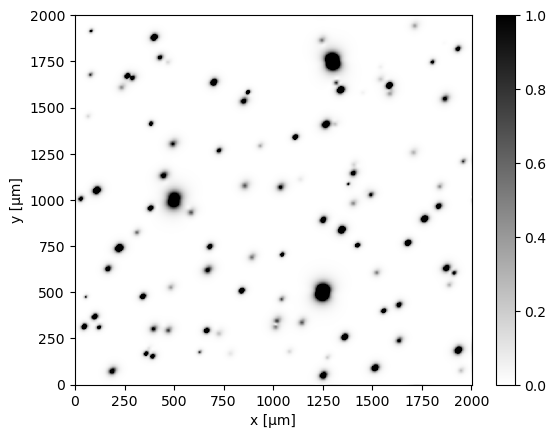

In [19]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")

## Detection

In [49]:
size_range=[20, 50]
size_increment=1.0
threshold=0.01
overlap=0.3
exclude_border=1
num_scales = 5
border_exclusion = 0
overlap_ratio = 0.3

grid_spacing = mg._utils._estimate_grid_spacing(data)
min_sigma, max_sigma = [0.5 * size for size in size_range]


y_indices, x_indices, detected_scales = skimage.feature.blob_log(
        data_tga_stretched,
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        threshold=threshold,
        num_sigma=num_scales,
        overlap=overlap_ratio,
        exclude_border=border_exclusion,
    ).T # Transpose the output to separate y, x, and scale values

blob_x_coords = data.x.values[x_indices.astype(int)]
blob_y_coords = data.y.values[y_indices.astype(int)]

blob_coords = (blob_x_coords, blob_y_coords)




In [50]:
size_multiplier=2
blob_sizes = detected_scales * np.sqrt(2) * grid_spacing * size_multiplier

In [51]:
windows = [
    [x - size, x + size, y - size, y + size]
    for size, x, y in zip(blob_sizes, *blob_coords)
]

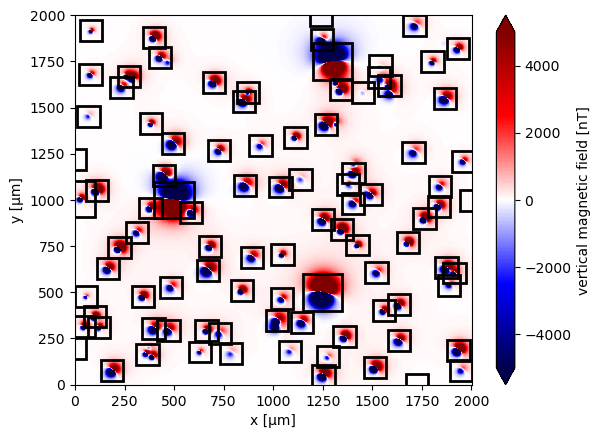

In [52]:
ax = plt.subplot(111)
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   